In [3]:
# Load modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter

In [4]:
# Load Major Salivary Tumor Listing data
salivary_df = pd.read_csv("SEEROutput.csv",low_memory=False)

In [40]:
# Look at data header
display(salivary_df.head())
display(salivary_df.info())
display(salivary_df.columns)

,Patient ID,Age recode with <1 year olds,Sex,Year of diagnosis,PRCDA 2020,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)",Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Primary Site - labeled,...,Age recode with single ages and 85+,Age recode with single ages and 90+,Race/ethnicity,Year of follow-up recode,Year of death recode,Marital status at diagnosis,Median household income inflation adj to 2022,Rural-Urban Continuum Code,Numerical_Age,Age_Binned
0,1154,75-79,Male,2016,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,79 years,79,White,2017,2017,Married (including common law),"$120,000+",Counties in metropolitan areas ge 1 million pop,79.0,75-79
1,2966,85+ years,Male,2002,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,85+ years,89,White,2009,2009,Married (including common law),"$110,000 - $119,999",Counties in metropolitan areas ge 1 million pop,89.0,85-89
2,3425,70-74,Male,2006,Not PRCDA,Asian or Pacific Islander,Non-Spanish-Hispanic-Latino,NHL - Extranodal,Malignant,C07.9-Parotid gland,...,72 years,72,Chinese,2021,Alive at last contact,Married (including common law),"$110,000 - $119,999",Counties in metropolitan areas ge 1 million pop,72.0,70-74
3,4395,65-69,Female,2019,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,65 years,65,White,2021,Alive at last contact,Divorced,"$120,000+",Counties in metropolitan areas ge 1 million pop,65.0,65-69
4,5623,55-59,Female,2019,Not PRCDA,Asian or Pacific Islander,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,56 years,56,Filipino,2021,Alive at last contact,Married (including common law),"$120,000+",Counties in metropolitan areas ge 1 million pop,56.0,55-59


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28030 entries, 0 to 28029
Data columns (total 66 columns):
 #   Column                                                     Non-Null Count  Dtype   
---  ------                                                     --------------  -----   
 0   Patient ID                                                 28030 non-null  int64   
 1   Age recode with <1 year olds                               28030 non-null  category
 2   Sex                                                        28030 non-null  category
 3   Year of diagnosis                                          28030 non-null  int64   
 4   PRCDA 2020                                                 28030 non-null  object  
 5   Race recode (W, B, AI, API)                                28030 non-null  category
 6   Origin recode NHIA (Hispanic, Non-Hisp)                    28030 non-null  object  
 7   Site recode ICD-O-3/WHO 2008                               28030 non-null  object  
 

None

Index(['Patient ID', 'Age recode with <1 year olds', 'Sex',
       'Year of diagnosis', 'PRCDA 2020', 'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3',
       'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
       'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
       'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
       'ICD-O-3 Hist/behav, malignant', 'Histology recode - broad groupings',
       'Site recode ICD-O-3/WHO 2008 (for SIRs)',
       'Combined Summary Stage (2004+)', 'Summary stage 2000 (1998-2017)',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'SEER historic stage A (1973-2015)', 'RX Summ--Surg Prim Site (1998+)',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq',
       'Reason no can

In [43]:
salivary_df['Primary Site - labeled'].unique()

array(['C07.9-Parotid gland', 'C08.0-Submandibular gland',
       'C08.9-Major salivary gland, NOS', 'C08.1-Sublingual gland',
       'C08.8-Overlapping lesion of major salivary glands'], dtype=object)

# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. For each relevant column, we will need to address missing values individually. They may be logged as, for example, 'XX' or '99'.


# Age Recode with 90+ and Other Categorical Adjustments

In [47]:
# Select relevant columns for demographic analysis
age_colname = 'Age recode with single ages and 90+'
age_bin_colname = 'Age_Binned'
race_colname = 'Race recode (W, B, AI, API)'
sex_colname = 'Sex'
ses_colname = 'Median household income inflation adj to 2022'

demographic_columns = [age_colname,race_colname,sex_colname, ses_colname]

# Remove 'years'
salivary_df[age_colname] = salivary_df[age_colname].str.replace(' years','') 

# Organize age column as a categorical with numerical order
numerical_years = salivary_df[age_colname].str.extract('(\d+)').astype(float)
# print(numerical_years[0].unique())
# Input numerical age data into the dataframe
salivary_df['Numerical_Age'] = numerical_years


# Define 5-year bins from 0 to 90+, using float to allow for infinity in the final bin
bins = np.concatenate([np.arange(0, 95, 5), [np.inf]])  # Include infinity in the last bin

# Create labels for the bins, including '90+' for the last bin
labels = [f'{i}-{i+4}' for i in range(0, 90, 5)] + ['90+']

# Apply pd.cut to create the binned age categories
salivary_df[age_bin_colname] = pd.cut(salivary_df['Numerical_Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Check the unique values of the new binned age column
# print(salivary_df[age_bin_colname].unique())

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_22785/3910966782.py:14: SyntaxWarning: invalid escape sequence '\d'
  numerical_years = salivary_df[age_colname].str.extract('(\d+)').astype(float)


In [48]:
# Create a mapping for values with leading zeros and handle special cases:
# - Convert '00' and '<1' to '≤1'
# - Remove leading zeros for values like '02', '03', etc.
# - Leave '90' as it is
sorted_ages = salivary_df[age_colname].unique()

age_mapping = {
    age: '≤1' if age == '00' or age == '<1' else (str(int(age)) if age.isdigit() and int(age) < 10 else age)
    for age in sorted_ages
}

# Replace values in the age column using the mapping
salivary_df[age_colname] = salivary_df[age_colname].replace(age_mapping)

# Get the sorted unique ages after the mapping has been applied
# Ensure '≤1' comes first, and handle sorting of numeric values correctly
sorted_ages = sorted(
    salivary_df[age_colname].unique(),
    key=lambda x: (-1 if '≤1' in x else float(x.replace('+', '').replace('≤', '').replace('<', ''))) if x != '90+' else 90
)

# Convert the 'age_colname' column to categorical with sorted order
salivary_df[age_colname] = pd.Categorical(salivary_df[age_colname], categories=sorted_ages, ordered=True)

# Sex order
sex_order = ['Female','Male']

# Convert Sex column to reflect new order
salivary_df[sex_colname] = pd.Categorical(
    salivary_df[sex_colname], categories=sex_order, ordered=True
)

# Race order
race_order = sorted(salivary_df[race_colname].unique())

# Convert race column to reflect new world order
salivary_df[race_colname] = pd.Categorical(
    salivary_df[race_colname], categories=race_order, ordered=True
)

display(salivary_df[age_colname].unique)



<bound method Series.unique of 0        79
1        89
2        72
3        65
4        56
         ..
28025    64
28026    74
28027    60
28028    87
28029    65
Name: Age recode with single ages and 90+, Length: 28030, dtype: category
Categories (90, object): ['≤1' < '2' < '3' < '4' ... '87' < '88' < '89' < '90+']>

In [126]:
# SES
# sorted_ses_mapping = {
#     salivary_df[ses_colname].unique()
# }
# Define the order of categories, excluding the "Unknown/missing/no match/Not 1990-2022"
socioeconomic_order = [
    "<$40,000", "$40,000 - $44,999", "$45,000 - $49,999", "$50,000 - $54,999",
    "$55,000 - $59,999", "$60,000 - $64,999", "$65,000 - $69,999", "$70,000 - $74,999",
    "$75,000 - $79,999", "$80,000 - $84,999", "$85,000 - $89,999", "$90,000 - $94,999",
    "$95,000 - $99,999", "$100,000 - $109,999", "$110,000 - $119,999", "$120,000+"
]

# Change to categorical
salivary_df[ses_colname] = pd.Categorical(
    salivary_df[ses_colname],
    categories=socioeconomic_order,
    ordered=True
)
salivary_df[ses_colname].unique()




['$120,000+', '$110,000 - $119,999', '$95,000 - $99,999', '$90,000 - $94,999', '$100,000 - $109,999', ..., NaN, '$55,000 - $59,999', '$50,000 - $54,999', '$45,000 - $49,999', '$40,000 - $44,999']
Length: 16
Categories (16, object): ['<$40,000' < '$40,000 - $44,999' < '$45,000 - $49,999' < '$50,000 - $54,999' ... '$95,000 - $99,999' < '$100,000 - $109,999' < '$110,000 - $119,999' < '$120,000+']

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_22785/1054103384.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  racevage_histplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_22785/1054103384.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sexvage_countplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_22785/1054103384.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ses_countplot = sns.histplot(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_22785/1054103384.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ses_countplot.set_xticklabels(ses_countplot.get_xtickla

Text(0, 0.5, 'Number of Cases')

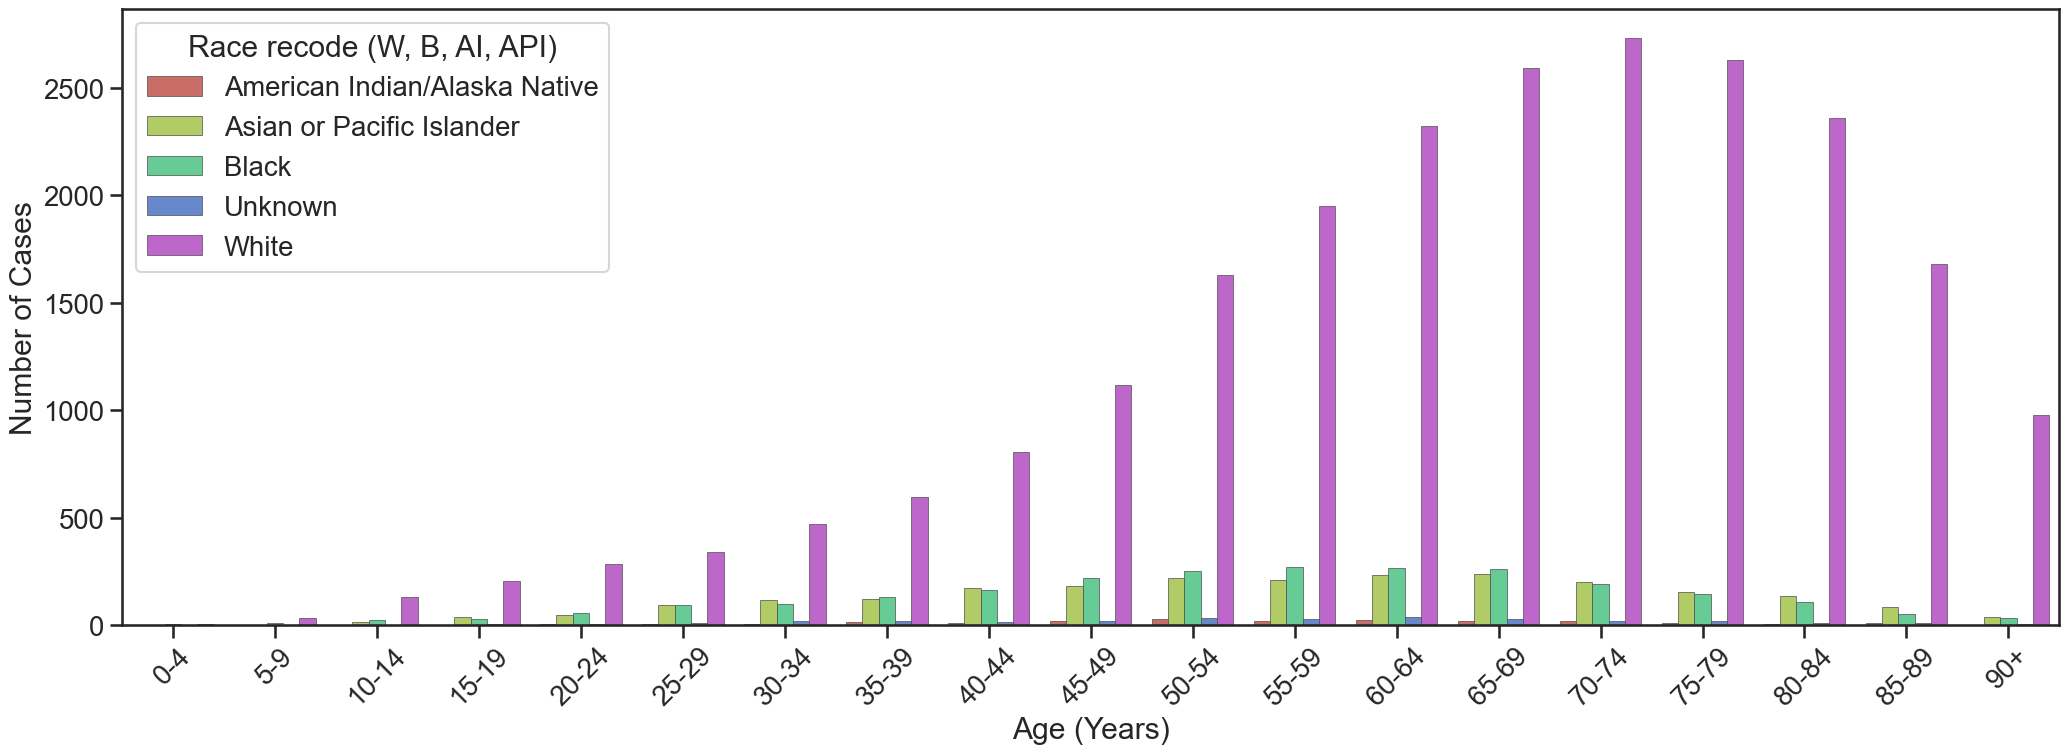

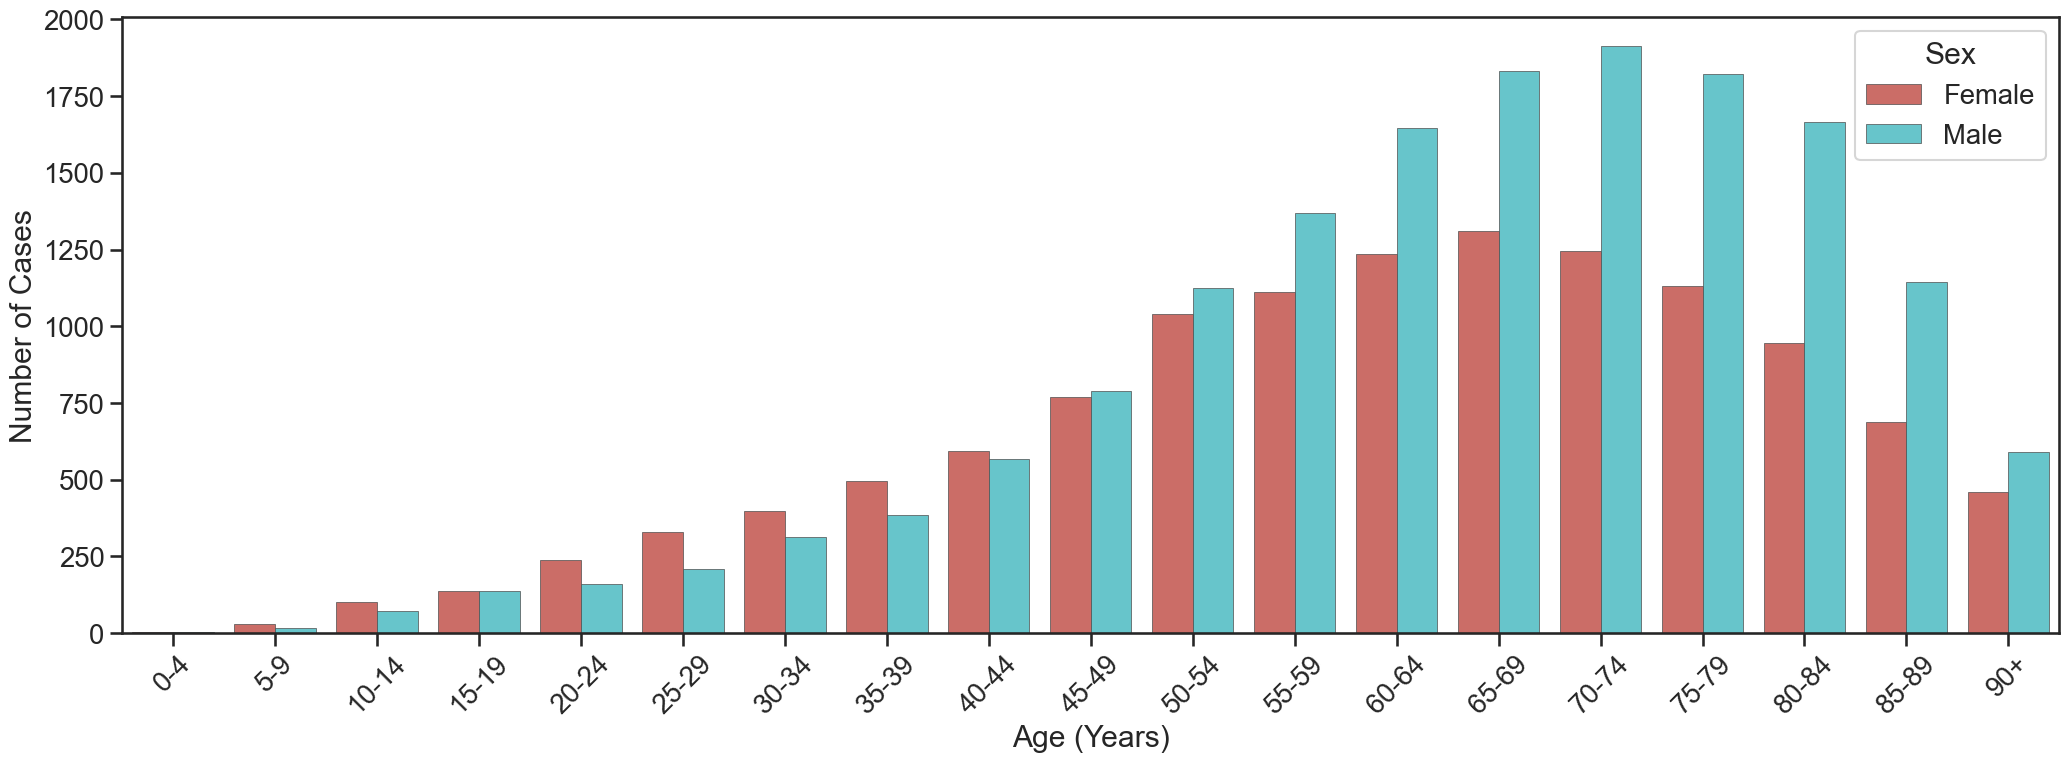

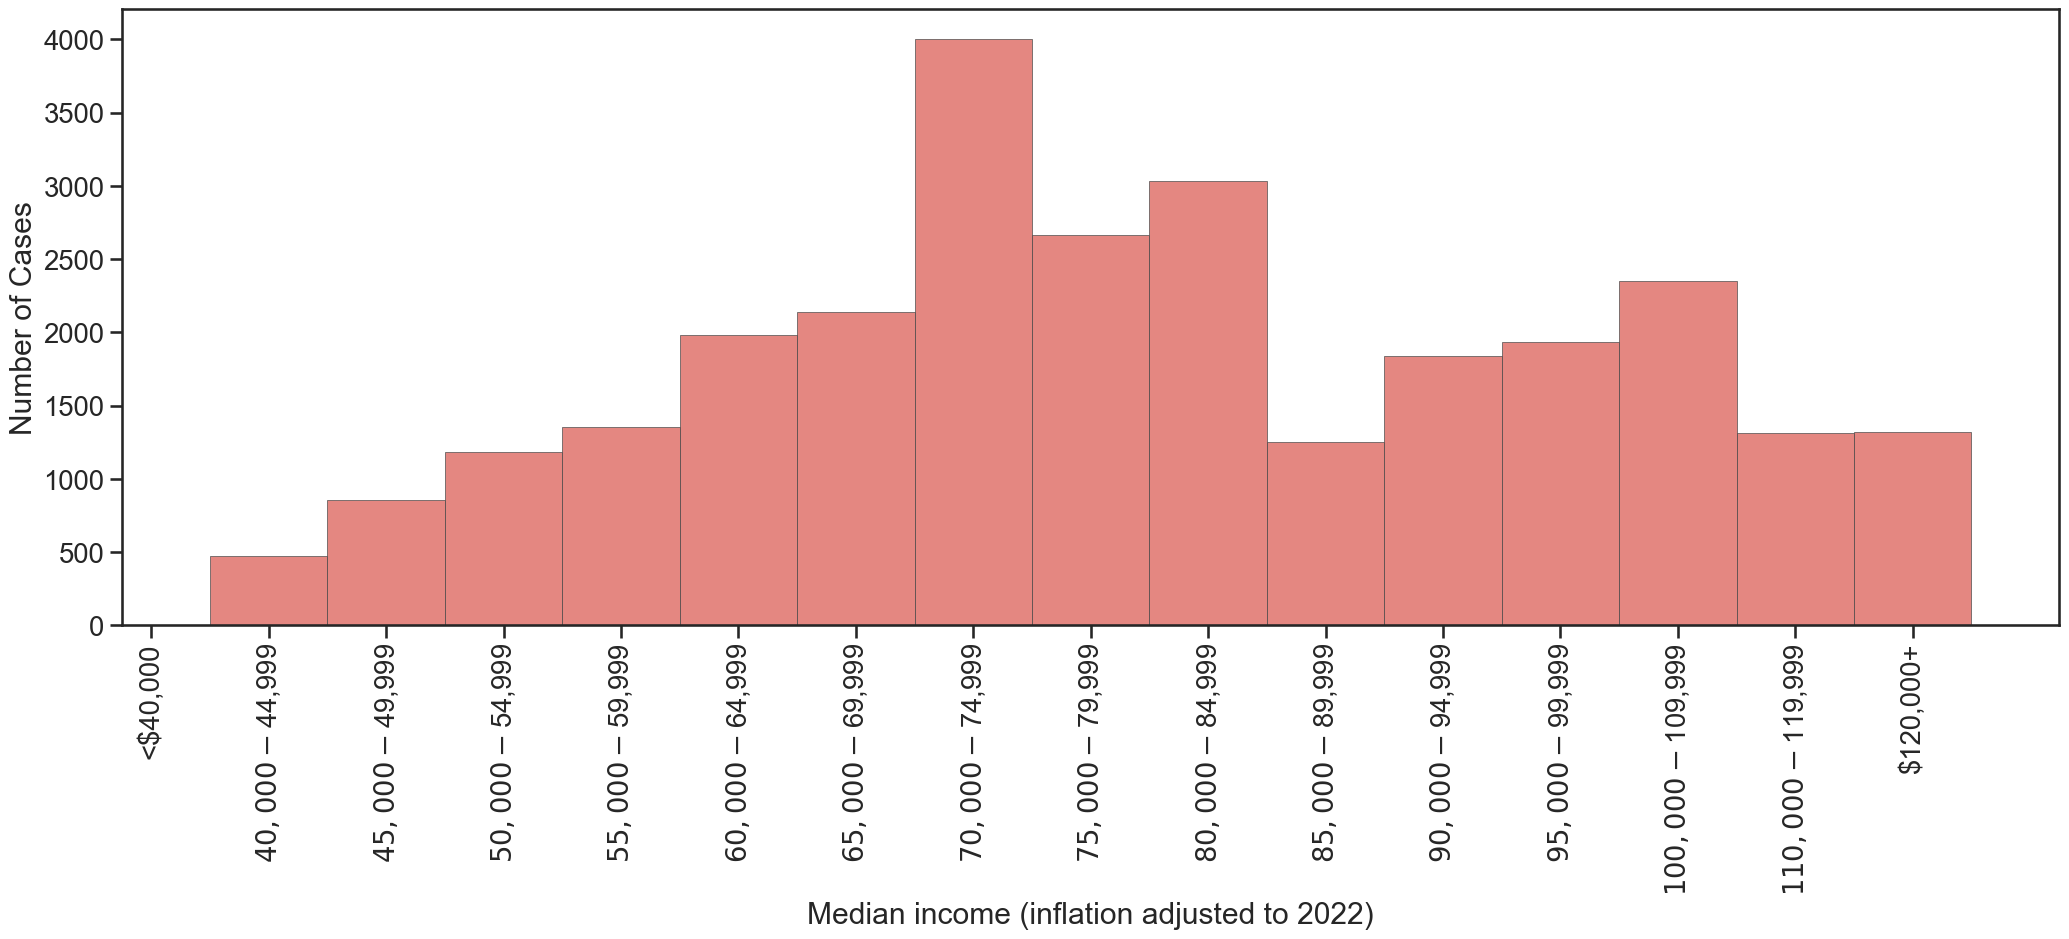

In [127]:


# Plot - countplot
sns.set_context('talk',font_scale=1.2)
sns.set_palette('hls')

# Race vs. Age
plt.figure(figsize=(25, 8))
racevage_histplot = sns.countplot(
    data=salivary_df,
    x=age_bin_colname,
    hue=race_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)
x_labels = racevage_histplot.get_xticklabels()

# Rotate x tick labels
racevage_histplot.set_xticklabels(x_labels, rotation=45)

racevage_histplot.set_xlabel('Age (Years)')
racevage_histplot.set_ylabel('Number of Cases')

# Sex vs. Age
plt.figure(figsize=(25, 8))
sexvage_countplot = sns.countplot(
    data=salivary_df,
    x=age_bin_colname,
    hue=sex_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

# Rotate x tick labels
x_labels = sexvage_countplot.get_xticklabels()
sexvage_countplot.set_xticklabels(x_labels, rotation=45)
# sexvage_countplot.set_xticklabels(x_labels,rotation=90)
sexvage_countplot.set_xlabel('Age (Years)')
sexvage_countplot.set_ylabel('Number of Cases')

plt.figure(figsize=(25, 8))
ses_countplot = sns.histplot(
    data=salivary_df,
    x=ses_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),rotation=90)
ses_countplot.set_xlabel('Median income (inflation adjusted to 2022)')
ses_countplot.set_ylabel('Number of Cases')


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_22785/662712754.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = salivary_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0, 0.5, '0-4'),
  Text(0, 1.5, '5-9'),
  Text(0, 2.5, '10-14'),
  Text(0, 3.5, '15-19'),
  Text(0, 4.5, '20-24'),
  Text(0, 5.5, '25-29'),
  Text(0, 6.5, '30-34'),
  Text(0, 7.5, '35-39'),
  Text(0, 8.5, '40-44'),
  Text(0, 9.5, '45-49'),
  Text(0, 10.5, '50-54'),
  Text(0, 11.5, '55-59'),
  Text(0, 12.5, '60-64'),
  Text(0, 13.5, '65-69'),
  Text(0, 14.5, '70-74'),
  Text(0, 15.5, '75-79'),
  Text(0, 16.5, '80-84'),
  Text(0, 17.5, '85-89'),
  Text(0, 18.5, '90+')])

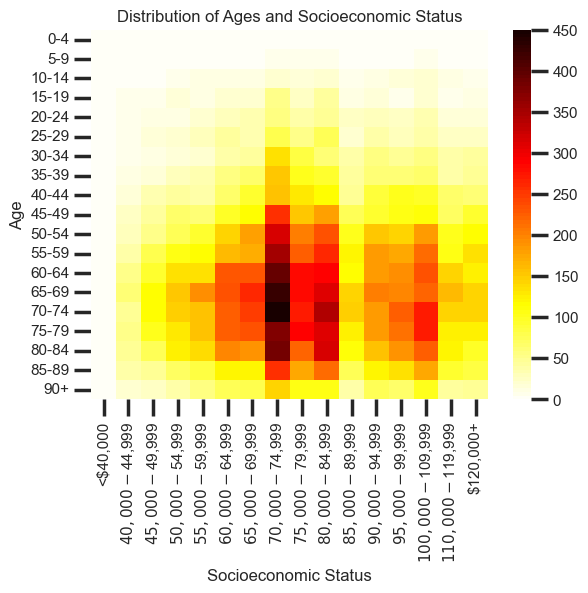

In [122]:
# Heatmap of age and socioeconomic
sns.set_context('poster',font_scale=.5)
# Create a pivot table that calculates the count of occurrences for each age and SES combination
# 
heatmap_data = salivary_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)

# Generate the RdYlGn palette with a specific number of colors
palette = sns.color_palette("hot_r",n_colors=100)
# Remove the darkest green, which is typically the last color in the RdYlGn palette
# You can adjust the indices depending on which colors you want to remove
modified_palette = palette[:-1]  # This removes the last color

# Convert the modified list of colors to a colormap
cmap = sns.color_palette(modified_palette, as_cmap=True)

# Create the heatmap
ses_heat = sns.heatmap(heatmap_data, cmap=cmap, annot=False, fmt='d')
plt.title('Distribution of Ages and Socioeconomic Status')
plt.xlabel('Median income')
plt.ylabel('Age (years)')
# plt.show()
# Rotate the y-axis labels
plt.yticks(rotation=0)  # Rotate y-axis labels to be horizontal (90º from the default)
# plt.close()

In [91]:
salivary_df[salivary_df['Site recode ICD-O-3/WHO 2008'].isin(['Salivary Gland','NHL - Extranodal'])]


,Patient ID,Age recode with <1 year olds,Sex,Year of diagnosis,PRCDA 2020,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)",Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Primary Site - labeled,...,Age recode with single ages and 85+,Age recode with single ages and 90+,Race/ethnicity,Year of follow-up recode,Year of death recode,Marital status at diagnosis,Median household income inflation adj to 2022,Rural-Urban Continuum Code,Numerical_Age,Age_Binned
0,1154,75-79,Male,2016,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,79 years,79,White,2017,2017,Married (including common law),"$120,000+",Counties in metropolitan areas ge 1 million pop,79.0,75-79
1,2966,85+ years,Male,2002,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,85+ years,89,White,2009,2009,Married (including common law),"$110,000 - $119,999",Counties in metropolitan areas ge 1 million pop,89.0,85-89
2,3425,70-74,Male,2006,Not PRCDA,Asian or Pacific Islander,Non-Spanish-Hispanic-Latino,NHL - Extranodal,Malignant,C07.9-Parotid gland,...,72 years,72,Chinese,2021,Alive at last contact,Married (including common law),"$110,000 - $119,999",Counties in metropolitan areas ge 1 million pop,72.0,70-74
3,4395,65-69,Female,2019,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,65 years,65,White,2021,Alive at last contact,Divorced,"$120,000+",Counties in metropolitan areas ge 1 million pop,65.0,65-69
4,5623,55-59,Female,2019,Not PRCDA,Asian or Pacific Islander,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,56 years,56,Filipino,2021,Alive at last contact,Married (including common law),"$120,000+",Counties in metropolitan areas ge 1 million pop,56.0,55-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28025,63340588,60-64,Female,2020,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,64 years,64,White,2021,Alive at last contact,Married (including common law),"$65,000 - $69,999","Counties in metropolitan areas of 250,000 to 1...",64.0,60-64
28026,63346248,70-74,Female,2021,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,74 years,74,White,2021,Alive at last contact,Single (never married),"$60,000 - $64,999",Counties in metropolitan areas of lt 250 thous...,74.0,70-74
28027,63347166,60-64,Male,2021,Not PRCDA,Black,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,60 years,60,Black,2021,Alive at last contact,Married (including common law),"$45,000 - $49,999","Counties in metropolitan areas of 250,000 to 1...",60.0,60-64
28028,63363403,85+ years,Male,2020,Not PRCDA,White,Non-Spanish-Hispanic-Latino,Salivary Gland,Malignant,C07.9-Parotid gland,...,85+ years,87,White,2021,2021,Married (including common law),"$75,000 - $79,999",Counties in metropolitan areas of lt 250 thous...,87.0,85-89


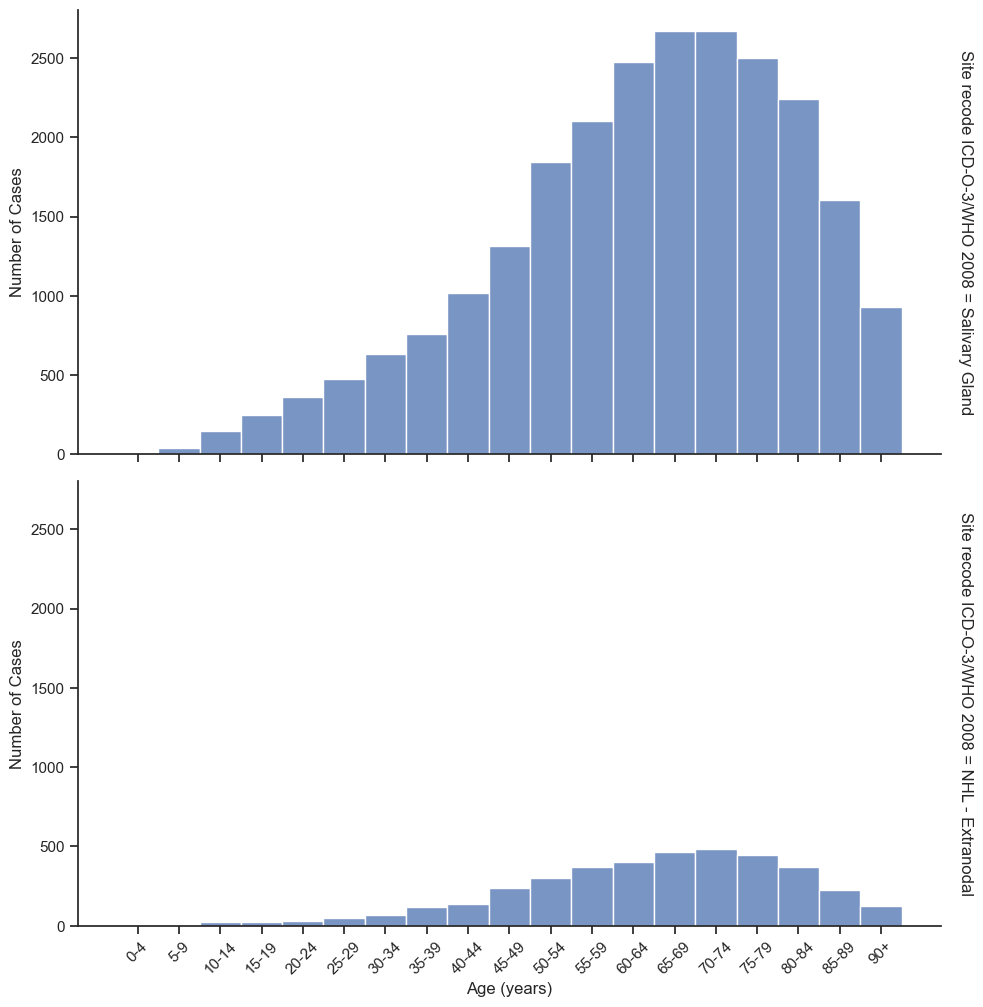

In [124]:
salivary_df['Site recode ICD-O-3/WHO 2008']
df = salivary_df[salivary_df['Site recode ICD-O-3/WHO 2008'].isin(['Salivary Gland','NHL - Extranodal'])]
sns.set_theme(style="ticks")
g = sns.displot(
    df, x="Age_Binned", row="Site recode ICD-O-3/WHO 2008",
    binwidth=1, height=5, facet_kws=dict(margin_titles=True),aspect=2, 
)
# Rotate the x-tick labels in each facet
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_xlabels('Age (years)')
g.set_ylabels('Number of Cases')

In [66]:
# Select relevant columns for clinical characteristics analysis
clinical_columns = ['Primary Site - labeled', 'Histologic Type ICD-O-3',
                     'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
                     'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
                     'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
                     'ICD-O-3 Hist/behav, malignant','SEER cause-specific death classification',
                    'SEER other cause of death classification', 'Survival months',
                    'Survival months flag', 'COD to site rec KM',
                    'COD to site recode ICD-O-3 2023 Revision',
                    'COD to site recode ICD-O-3 2023 Revision Expanded (1999+)',
                    'Vital status recode (study cutoff used)', 'Sequence number',
                    'First malignant primary indicator', 'Primary by international rules']

# Creating a summary for clinical characteristics
clinical_summary = salivary_df[clinical_columns]

# Display the summary
display(clinical_summary)


,Primary Site - labeled,Primary Site,Histologic Type ICD-O-3,Grade Recode (thru 2017),Derived Summary Grade 2018 (2018+),Grade Clinical (2018+),Grade Pathological (2018+),Laterality,Diagnostic Confirmation,ICD-O-3 Hist/behav,...,SEER other cause of death classification,Survival months,Survival months flag,COD to site rec KM,COD to site recode ICD-O-3 2023 Revision,COD to site recode ICD-O-3 2023 Revision Expanded (1999+),Vital status recode (study cutoff used),Sequence number,First malignant primary indicator,Primary by international rules
0,C07.9-Parotid gland,79,8041,Poorly differentiated; Grade III,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,"8041/3: Small cell carcinoma, NOS",...,Dead (attributable to causes other than this c...,14,Complete dates are available and there are mor...,Myeloma,Plasma Cell Neoplasms and Immunoproliferative ...,Plasma Cell Neoplasms,Dead,3rd of 3 or more primaries,No,Yes
1,C07.9-Parotid gland,79,8071,Moderately differentiated; Grade II,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,"8071/3: Squamous cell carcinoma, keratinizing,...",...,Dead (attributable to causes other than this c...,86,Complete dates are available and there are mor...,Melanoma of the Skin,Melanoma Of The Skin,Melanoma Of The Skin,Dead,2nd of 2 or more primaries,No,Yes
2,C07.9-Parotid gland,79,9699,Unknown,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,9699/3: Extranodal marginal zone lymphoma of m...,...,Alive or dead due to cancer,188,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,2nd of 2 or more primaries,No,Yes
3,C07.9-Parotid gland,79,8200,Unknown,9,9,9,Right - origin of primary,Positive histology,8200/3: Adenoid cystic carcinoma,...,Alive or dead due to cancer,25,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,4th of 4 or more primaries,No,Yes
4,C07.9-Parotid gland,79,8502,Unknown,9,9,9,Left - origin of primary,Positive histology,8502/3: Secretory carcinoma of breast,...,Alive or dead due to cancer,30,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28025,C07.9-Parotid gland,79,8200,Unknown,9,9,9,Left - origin of primary,Positive histology,8200/3: Adenoid cystic carcinoma,...,Alive or dead due to cancer,9,Incomplete dates are available and there canno...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes
28026,C07.9-Parotid gland,79,8941,Unknown,9,9,9,Right - origin of primary,"Positive exfoliative cytology, no positive his...",8941/3: Carcinoma in pleomorphic adenoma,...,Alive or dead due to cancer,4,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes
28027,C07.9-Parotid gland,79,8000,Unknown,9,9,9,Left - origin of primary,Positive histology,"8000/3: Neoplasm, malignant",...,Alive or dead due to cancer,5,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,1st of 2 or more primaries,Yes,Yes
28028,C07.9-Parotid gland,79,8070,Unknown,9,9,9,Right - origin of primary,Positive histology,"8070/3: Squamous cell carcinoma, NOS",...,Alive or dead due to cancer,5,Complete dates are available and there are mor...,"Trachea, Mediastinum and Other Respiratory Organs","Trachea, And Respiratory Other","Trachea, And Respiratory Other",Dead,One primary only,Yes,Yes


In [51]:
salivary_df['event_occurred'] = salivary_df['SEER other cause of death classification'].apply(
    lambda x: 1 if x == 'Alive or dead due to cancer'
# else 2 if x == 'Dead (missing/unknown COD)'
else 0)

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data into the model
kmf.fit(durations=salivary_df['Survival months'], event_observed=salivary_df['event_occurred'])

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


TypeError: Wrong dtype 'object'.

In [108]:
print(salivary_df['SEER other cause of death classification'].unique())

print(salivary_df['event_occurred'].unique())

salivary_df['Survival months']

['Dead (attributable to causes other than this cancer dx)'
 'Alive or dead due to cancer' 'Dead (missing/unknown COD)'
 'N/A not seq 0-59']


KeyError: 'event_occurred'